In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from tqdm import tqdm
from tqdm import trange

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay

import random

In [2]:
from AgentBasedModel import *
from AgentBasedModel.extra import *
from AgentBasedModel.visualization import *
from AgentBasedModel.visualization.other import plot_book
from AgentBasedModel.visualization.other import plot_full_book
from AgentBasedModel.visualization.trader import *
from random import randint

In [3]:
more_market_agents=[40, 40, 40, 1]

In [4]:
run utils_nikita//functions.ipynb

# Download data - no LOB

In [5]:
all_data_names = ['huge_data', 'huge_data_no_mm', 'huge_data_undervalued', 'huge_data_undervalued_no_mm']

cur_df = pd.read_csv(f'generated_data/{all_data_names[0]}')

separation_column = []

for i in range(cur_df.shape[0]//250):
    separation_column += [i] * 250

In [6]:
enormous_data = {}

for i in range(4):
    current_division = []
    cur_df = pd.read_csv(f'generated_data/{all_data_names[i]}').drop(['Unnamed: 0'], axis=1)
    cur_df['sep_col'] = separation_column
    
    for j in range(cur_df.shape[0] // 250):
        current_division.append(cur_df[cur_df['sep_col'] == j].reset_index(drop=True).drop(['sep_col'], axis=1))
    
    
    enormous_data[all_data_names[i]] = current_division

In [7]:
huge_data = enormous_data['huge_data']
huge_data_no_mm = enormous_data['huge_data_no_mm']
huge_data_undervalued = enormous_data['huge_data_undervalued']
huge_data_undervalued_no_mm = enormous_data['huge_data_undervalued_no_mm']

all_data = [huge_data, huge_data_no_mm, huge_data_undervalued, huge_data_undervalued_no_mm]

# Download data with LOB

In [8]:
sim_n = 500
iter_n = 250

huge_data_bid = []
huge_data_ask = []

for i in trange(sim_n):

    bids_simulation = []
    asks_simulation = []
    
    for j in range(iter_n):
        cur_bid = pd.read_csv(f'data/huge_data_lob/bids/sim_{i}_iter_{j}.csv')
        cur_ask = pd.read_csv(f'data/huge_data_lob/asks/sim_{i}_iter_{j}.csv')

        bids_simulation.append(cur_bid)
        asks_simulation.append(cur_ask)
        
#         break

    huge_data_bid.append(bids_simulation)
    huge_data_ask.append(asks_simulation)

  0%|          | 1/500 [00:01<16:06,  1.94s/it]

KeyboardInterrupt



In [195]:
huge_data_features = pd.read_csv('data/huge_data_lob/huge_data_features.csv')

separation_column = []

for i in range(huge_data_features.shape[0]//250):
    separation_column += [i] * 250

huge_data_features['sep_col'] = separation_column

current_division = []

for j in range(huge_data_features.shape[0] // 250):
    current_division.append(huge_data_features[huge_data_features['sep_col'] == j].reset_index(drop=True).drop(['sep_col'], axis=1))

huge_data_features = current_division

In [10]:
shift_percentage = {}
shift_percentage['huge_data'] = [(1, 0.0004), (5, 0.001), (10, 0.0017)]
shift_percentage['huge_data_no_mm'] = [(1, 0.001), (5, 0.002265), (10, 0.003)]
shift_percentage['huge_data_undervalued'] = [(1, 0.0008), (5, 0.0025), (10, 0.004)]
shift_percentage['huge_data_undervalued_no_mm'] = [(1, 0.00105), (5, 0.003), (10, 0.0042)]

# NN classification

In [11]:
# pip install torch

In [196]:
import torch
from torch import nn
from torch.utils.data import DataLoader

## Dataset functions

In [197]:
class trainDataset():
    def __init__(self, data_x, data_y, device="cuda"):
        self.data = data_x
        self.device = device
        self.labels = data_y
        
    def __getitem__(self, x):
        data_x = self.data.iloc[x]
        data_y = [self.labels.iloc[x]]
        
        data = torch.Tensor(data_x.values).to(self.device)
        label = torch.Tensor(data_y).type(torch.LongTensor).to(self.device)
        
        return data, label
    
    def __len__(self):
        return len(self.labels)

In [198]:
class trainDataset_w_LOB():
    def __init__(self, data_x, data_y, min_iteration_indeces, max_iteration_indeces, 
                 data_bid, data_ask, iterations_length=250, device="cuda"):
        
        self.data = data_x
        self.device = device
        self.labels = data_y
        
        self.bids = huge_data_bid
        self.asks = huge_data_ask

        self.min_iteration_indeces = min_iteration_indeces
        self.max_iteration_indeces = max_iteration_indeces

        self.iterations_length = iterations_length
        #[0][min_iteration_indeces: max_iteration_indeces + 1]

        # preparing bid and ask info

        collected_bids = []
        collected_asks = []

        for i in range(len(self.bids)):
            collected_bids = collected_bids + self.bids[i][self.min_iteration_indeces: self.max_iteration_indeces + 1]
            collected_asks = collected_asks + self.asks[i][self.min_iteration_indeces: self.max_iteration_indeces + 1]

        self.bids = collected_bids
        self.asks = collected_asks

        # print(len(self.labels), len(self.bids), len(self.asks))
        
    def __getitem__(self, x):
        data_x = self.data.iloc[x]
        data_y = [self.labels.iloc[x]]

        data_bid = self.bids[x][['price', 'qty']]
        data_ask = self.asks[x][['price', 'qty']]
        
        data = torch.Tensor(data_x.values).to(self.device)
        label = torch.Tensor(data_y).type(torch.LongTensor).to(self.device)

        data_bid = torch.Tensor(data_bid.values[:16]).to(self.device)
        data_ask = torch.Tensor(data_ask.values[:16]).to(self.device)

        data = data.unsqueeze(dim=-1)
        
        result = torch.cat((data.T, data_bid.T, data_ask.T))
        result = result.reshape([result.shape[0] * result.shape[1]])
        
        return result, label
    
    def __len__(self):
        return len(self.labels)

In [199]:
class trainDataset_only_LOB():
    def __init__(self, data_x, data_y, min_iteration_indeces, max_iteration_indeces, 
                 data_bid, data_ask, iterations_length=250, device="cuda"):
        
        self.data = data_x
        self.device = device
        self.labels = data_y
        
        self.bids = huge_data_bid
        self.asks = huge_data_ask

        self.min_iteration_indeces = min_iteration_indeces
        self.max_iteration_indeces = max_iteration_indeces

        self.iterations_length = iterations_length
        #[0][min_iteration_indeces: max_iteration_indeces + 1]

        # preparing bid and ask info

        collected_bids = []
        collected_asks = []

        for i in range(len(self.bids)):
            collected_bids = collected_bids + self.bids[i][self.min_iteration_indeces: self.max_iteration_indeces + 1]
            collected_asks = collected_asks + self.asks[i][self.min_iteration_indeces: self.max_iteration_indeces + 1]

        self.bids = collected_bids
        self.asks = collected_asks

        # print(len(self.labels), len(self.bids), len(self.asks))
        
    def __getitem__(self, x):
#         data_x = self.data.iloc[x]
        data_y = [self.labels.iloc[x]]

        data_bid = self.bids[x][['price', 'qty']]
        data_ask = self.asks[x][['price', 'qty']]
        
#         data = torch.Tensor(data_x.values).to(self.device)
        label = torch.Tensor(data_y).type(torch.LongTensor).to(self.device)

        data_bid = torch.Tensor(data_bid.values[:16]).to(self.device)
        data_ask = torch.Tensor(data_ask.values[:16]).to(self.device)

#         data = data.unsqueeze(dim=-1)
        
        result = torch.cat((data_bid.T, data_ask.T))
        result = result.reshape([result.shape[0] * result.shape[1]])
        
        return result, label
    
    def __len__(self):
        return len(self.labels)

## NN Classifiers architectures

In [16]:
class LSTM_model_5(nn.Module):
    def __init__(self):
        super(LSTM_model_5, self).__init__()
        self.lstm = nn.LSTM(16, 30, num_layers=5, batch_first=False)
        self.linear = nn.Linear(30, 20)
        self.linear2 = nn.Linear(20, 3)
#         self.sigmoid = nn.Sigmoid()

        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        h_0 = torch.zeros(5, 30).requires_grad_().to(device)
        c_0 = torch.zeros(5, 30).requires_grad_().to(device)
        
        output, (h_index, c_index) = self.lstm(x, (h_0, c_0)) # 5x30
            
        output = self.linear(output)
        
        output = self.relu(output)
        
        output = self.linear2(output)
        
        output = self.softmax(output)
        
        return output

In [17]:
class SimpleModel(nn.Module):
    def __init__(self):
        
        super(SimpleModel, self).__init__()
        
        self.linear = nn.Linear(16, 30)
        self.linear2 = nn.Linear(30, 20)
        self.linear3 = nn.Linear(20, 10)
        self.linear4 = nn.Linear(10, 3)
        
#         self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        x = self.softmax(x)
        
        return x

In [19]:
class SimpleModel_LOB(nn.Module):
    def __init__(self):
        
        super(SimpleModel_LOB, self).__init__()
        
        self.linear = nn.Linear(80, 160)
        self.linear2 = nn.Linear(160, 220)
        self.linear3 = nn.Linear(220, 160)
        self.linear4 = nn.Linear(160, 80)
        self.linear5 = nn.Linear(80, 40)
        self.linear6 = nn.Linear(40, 20)
        self.linear7 = nn.Linear(20, 3)
        
#         self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        x = self.relu(x)
        x = self.linear5(x)
        x = self.relu(x)
        x = self.linear6(x)
        x = self.relu(x)
        x = self.linear7(x)
        
        x = self.softmax(x)
        
        return x

In [20]:
class SimpleModel_LOB_only(nn.Module):
    def __init__(self):
        
        super(SimpleModel_LOB_only, self).__init__()
        
        self.linear = nn.Linear(64, 160)
        self.linear2 = nn.Linear(160, 220)
        self.linear3 = nn.Linear(220, 160)
        self.linear4 = nn.Linear(160, 80)
        self.linear5 = nn.Linear(80, 40)
        self.linear6 = nn.Linear(40, 20)
        self.linear7 = nn.Linear(20, 3)
        
#         self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        x = self.linear(x)
        x = self.relu(x)
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.linear3(x)
#         x = self.relu(x)
        x = self.linear4(x)
        x = self.relu(x)
        x = self.linear5(x)
        x = self.relu(x)
        x = self.linear6(x)
        x = self.relu(x)
        x = self.linear7(x)
        
        x = self.softmax(x)
        
        return x

## Training function

In [21]:
def train_lstm(model, train_ds, eval_ds, loss_f, n_epoch=1, batch_size=32, 
               learning_rate=0.00001, device='cpu', available_shift=5):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model.to(device)
    
    # general recording
    training_loss = []
    evaluation_loss = []

    training_accuracy = []
    evaluation_accuracy = []
    
    for epoch in trange(n_epoch):

        # epoch performance recording
        epoch_train_loss = 0
        epoch_evaluation_loss = 0

        epoch_train_loss = 0
        epoch_evaluation_accuracy = 0

        epoch_evaluation_accuracy_list = []
        
        # training cycle
        
        # data_y = train_df['difference'] + 1
        # data_x =  train_df.drop(['difference'], axis=1)
        # train_ds = trainDataset(data_x, data_y, device=device)

        # train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)

        model.train()

        n_of_iterations = 0
        
        for i in trange(available_shift, len(train_ds)):
                
#             data = el[0]
#             target = el[1].squeeze()
            
            data = []
            target = []
            
            for j in range(available_shift):
                data.append(train_ds[i - available_shift + j][0].unsqueeze(0))
                target.append(train_ds[i - available_shift + j][1])
#                 print(train_ds[i - available_shift + j][0].unsqueeze(0), i - available_shift + j)
            
            data = torch.cat(data, dim=0)
            target = torch.cat(target, dim=0)
            
#             print(data)
#             data = torch.Tensor(data).to(device)
#             target = torch.Tensor(target).to(device)

            y_pred = model(data)
#             print(y_pred, target)
            
            optimizer.zero_grad()
            
            loss = loss_f(y_pred, target)

            loss.backward()

            optimizer.step()

            epoch_train_loss += loss
            n_of_iterations += 1


#             if n_of_iterations == 100:
#                 break
            
        epoch_train_loss = epoch_train_loss/n_of_iterations

        # testing cycle
        # data_y = eval_df['difference'] + 1
        # data_x =  eval_df.drop(['difference'], axis=1)
        # eval_ds = trainDataset(data_x, data_y, device=device)

#         eval_dl = DataLoader(eval_ds, batch_size=batch_size, shuffle=False)

        model.eval()
        
        predicted_classes = []
        true_classes = []
        
        for i in trange(available_shift, len(eval_ds)):
                
#             data = el[0]
#             target = el[1].squeeze()
            
            data = []
            target = eval_ds[i][1]
            
            for j in range(available_shift):
                data.append(eval_ds[i - available_shift + j][0].unsqueeze(0))
            
            data = torch.cat(data, dim=0)
#             data = torch.Tensor(data).to(device)
#             target = torch.Tensor(target).to(device)
    
            y_pred = model(data)[-1].unsqueeze(0)
    
            loss = loss_f(y_pred, target)
            epoch_evaluation_loss = loss

            y_classes = torch.argmax(y_pred, dim=1)
#             print(y_classes.values, target.values)
            
#             print(list(y_classes.to('cpu')), list(target.to('cpu')))
    
            predicted_classes = predicted_classes + y_classes.to('cpu').tolist()
            true_classes = true_classes + target.to('cpu').tolist()

#             break

        print(predicted_classes[-20:-10], true_classes[-20:-10])

        epoch_evaluation_accuracy = accuracy_score(predicted_classes, true_classes)

        print(f"epoch {epoch} train loss - {epoch_train_loss}, eval loss - {epoch_evaluation_loss}, accuracy - {round(epoch_evaluation_accuracy, 2)}")
        
        training_loss.append(epoch_train_loss)
        evaluation_loss.append(epoch_evaluation_loss)
        epoch_evaluation_accuracy_list.append(round(epoch_evaluation_accuracy, 2))
        

In [22]:
def train_nn(model, train_ds, eval_ds, loss_f, n_epoch=1, batch_size=32, learning_rate=0.00001, device='cpu'):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model.to(device)
    
    # general recording
    training_loss = []
    evaluation_loss = []

    training_accuracy = []
    evaluation_accuracy = []
    
    for epoch in trange(n_epoch):

        # epoch performance recording
        epoch_train_loss = 0
        epoch_evaluation_loss = 0

        epoch_train_loss = 0
        epoch_evaluation_accuracy = 0

        epoch_evaluation_accuracy_list = []
        
        # training cycle
        
        # data_y = train_df['difference'] + 1
        # data_x =  train_df.drop(['difference'], axis=1)
        # train_ds = trainDataset(data_x, data_y, device=device)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)

        model.train()

        n_of_iterations = 0
        for el in train_dl:
                
            data = el[0]
            target = el[1].squeeze()

            y_pred = model(data)
            
            optimizer.zero_grad()
            
            loss = loss_f(y_pred, target)

            loss.backward()

            optimizer.step()

            epoch_train_loss += loss
            n_of_iterations += 1


#             if n_of_iterations == 100:
#                 break
            
        epoch_train_loss = epoch_train_loss/n_of_iterations

        # testing cycle
        # data_y = eval_df['difference'] + 1
        # data_x =  eval_df.drop(['difference'], axis=1)
        # eval_ds = trainDataset(data_x, data_y, device=device)

        eval_dl = DataLoader(eval_ds, batch_size=batch_size, shuffle=False)

        model.eval()
        
        predicted_classes = []
        true_classes = []
        
        for el in eval_dl:
                
            data = el[0]
            target = el[1].squeeze()
    
            y_pred = model(data)
    
            loss = loss_f(y_pred, target)
            epoch_evaluation_loss = loss

            y_classes = torch.argmax(y_pred, dim=1)
#             print(y_classes.values, target.values)
            
#             print(list(y_classes.to('cpu')), list(target.to('cpu')))
    
            predicted_classes = predicted_classes + y_classes.to('cpu').tolist()
            true_classes = true_classes + target.to('cpu').tolist()

#             break

        print(predicted_classes[-20:-10], true_classes[-20:-10])

        epoch_evaluation_accuracy = accuracy_score(predicted_classes, true_classes)

        print(f"epoch {epoch} train loss - {epoch_train_loss}, eval loss - {epoch_evaluation_loss}, accuracy - {round(epoch_evaluation_accuracy, 2)}")
        
        training_loss.append(epoch_train_loss)
        evaluation_loss.append(epoch_evaluation_loss)
        epoch_evaluation_accuracy_list.append(round(epoch_evaluation_accuracy, 2))
        

In [23]:
list(torch.Tensor([1, 2, 3, 4, 1, 2, 2]).to('cpu').tolist())

[1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 2.0]

In [24]:
(100 * 250) % 32 

8

## Training - only collected features

In [254]:
shift_percentage = {}
shift_percentage['huge_data'] = [(1, 0.0004), (5, 0.001), (10, 0.0017)]
shift_percentage['huge_data_no_mm'] = [(1, 0.00129), (5, 0.002265), (10, 0.003)]
shift_percentage['huge_data_undervalued'] = [(1, 0.0008), (5, 0.0025), (10, 0.004)]
shift_percentage['huge_data_undervalued_no_mm'] = [(1, 0.00105), (5, 0.003), (10, 0.0042)]

In [255]:
device='cuda'

In [256]:
# train_df_5 = prepare_huge_data(new_huge_data_features[:400], shift=shift_percentage['huge_data'][1][0], percentage_down=shift_percentage['huge_data'][1][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)
# eval_df_5 = prepare_huge_data(new_huge_data_features[400:], shift=shift_percentage['huge_data'][1][0], percentage_down=shift_percentage['huge_data'][1][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)

# loss_f = nn.CrossEntropyLoss()

In [257]:
# train_df_5 = prepare_huge_data(huge_data_features[:400], shift=shift_percentage['huge_data'][1][0], percentage_down=shift_percentage['huge_data'][1][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)
# eval_df_5 = prepare_huge_data(huge_data_features[400:], shift=shift_percentage['huge_data'][1][0], percentage_down=shift_percentage['huge_data'][1][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)

# loss_f = nn.CrossEntropyLoss()

train_df_1 = prepare_huge_data(huge_data_features[:400], shift=shift_percentage['huge_data'][0][0], percentage_down=shift_percentage['huge_data'][0][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)
eval_df_1 = prepare_huge_data(huge_data_features[400:], shift=shift_percentage['huge_data'][0][0], percentage_down=shift_percentage['huge_data'][0][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)

loss_f = nn.CrossEntropyLoss()

In [259]:
shift_percentage['huge_data'][0][0]

1

In [260]:
shift_percentage['huge_data'][0][1]

0.0004

In [268]:
len(huge_data_features) * huge_data_features[0].shape[0]

125000

In [263]:
train_df_5.shape

(90000, 18)

In [264]:
train_df_1.shape

(91600, 18)

In [270]:
train_df_5.head()

,Unnamed: 0,bid_ask_volume_imbalance_1,bid_ask_volume_imbalance_3,bid_ask_volume_imbalance_5,bid_ask_volume_imbalance_10,sign_transaction_volume_1,sign_transaction_volume_5,sign_transaction_volume_10,sign_transaction_volume_20,all_transaction_volume_1,dividends_previous_divided,return_1,return_5,return_10,return_20,difference,bid_ask_spread_percentage,fundamental_v_norm
0,20,0.157895,0.230769,0.156863,-0.061611,-0.107692,0.214545,0.130252,0.126513,65,1.004824,0.001001,0.000501,0.000751,-0.000751,0,0.002002,0.003818
1,21,-0.565217,-0.538462,-0.428571,-0.325967,-0.360000,0.112782,0.120654,0.121577,50,1.000242,0.000000,-0.001502,0.001001,-0.000751,1,0.009009,0.000242
2,22,-0.703704,0.674009,0.437037,0.197802,-0.463415,0.030075,0.067210,0.096703,41,0.999022,0.004732,0.006476,0.005479,0.003985,0,0.001494,-0.005705
3,23,0.939394,0.815789,0.718876,0.362162,-0.137931,-0.090909,0.030303,0.064200,58,0.998005,0.000498,0.008215,0.004481,0.005975,-1,0.000498,-0.002492
4,24,0.898990,0.831776,0.781659,0.607717,0.368421,-0.150794,0.070994,0.064018,38,1.000087,-0.005759,0.000501,0.000501,-0.000751,1,0.010015,0.005846


In [271]:
random.seed(2114)

data_y = train_df_1['difference'] + 1
data_x =  train_df_1.drop(['difference', 'Unnamed: 0'], axis=1)
train_ds = trainDataset(data_x, data_y, device=device)

data_y = eval_df_1['difference'] + 1
data_x =  eval_df_1.drop(['difference', 'Unnamed: 0'], axis=1)
eval_ds = trainDataset(data_x, data_y, device=device)

<Axes: >

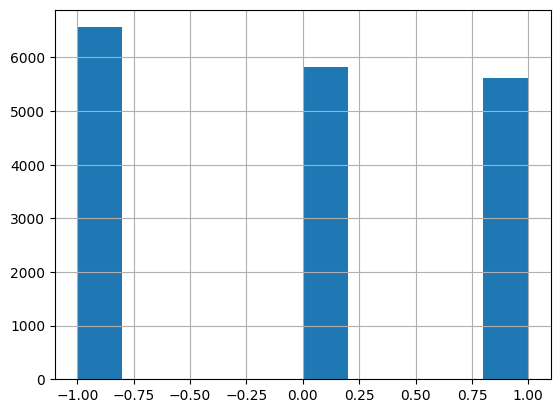

In [276]:
train_df_5[train_df_5.index % 5 == 0]['difference'].hist()

<Axes: >

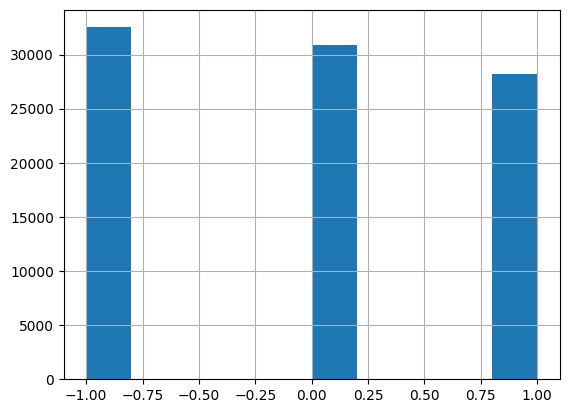

In [273]:
train_df_1['difference'].hist()

### simple connected nn

In [277]:
random.seed(2114)
torch.manual_seed(2114)
simple_model = SimpleModel()

In [278]:
simple_model.linear.weight[0][0].item()

0.17340821027755737

In [279]:
device='cuda'

In [280]:
train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=10, batch_size=32, learning_rate=0.001, device=device)

 10%|█         | 1/10 [00:35<05:21, 35.76s/it]

[2, 1, 1, 2, 1, 2, 2, 0, 2, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 0 train loss - 1.0204157829284668, eval loss - 0.9004448652267456, accuracy - 0.55


 20%|██        | 2/10 [01:11<04:45, 35.69s/it]

[2, 1, 1, 2, 2, 2, 2, 0, 2, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 1 train loss - 0.9686422944068909, eval loss - 0.9314071536064148, accuracy - 0.56


 30%|███       | 3/10 [01:46<04:08, 35.46s/it]

[2, 1, 1, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 2 train loss - 0.962050199508667, eval loss - 0.9598234295845032, accuracy - 0.56


 40%|████      | 4/10 [02:20<03:29, 34.93s/it]

[2, 1, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 3 train loss - 0.9582390785217285, eval loss - 0.9807316064834595, accuracy - 0.57


 50%|█████     | 5/10 [02:56<02:56, 35.37s/it]

[2, 1, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 4 train loss - 0.9558948874473572, eval loss - 0.9807872772216797, accuracy - 0.57


 60%|██████    | 6/10 [03:31<02:20, 35.06s/it]

[2, 1, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 5 train loss - 0.9539851546287537, eval loss - 0.9806004762649536, accuracy - 0.57


 70%|███████   | 7/10 [04:06<01:45, 35.22s/it]

[2, 1, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 6 train loss - 0.9526342749595642, eval loss - 0.9810965657234192, accuracy - 0.57


 80%|████████  | 8/10 [04:38<01:08, 34.09s/it]

[2, 1, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 7 train loss - 0.9510550498962402, eval loss - 0.9842376708984375, accuracy - 0.57


 90%|█████████ | 9/10 [05:13<00:34, 34.40s/it]

[2, 1, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 8 train loss - 0.9493147134780884, eval loss - 0.9891499280929565, accuracy - 0.58


100%|██████████| 10/10 [05:49<00:00, 34.95s/it]

[2, 1, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 9 train loss - 0.9475113153457642, eval loss - 0.9926446080207825, accuracy - 0.58


In [281]:
train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=10, batch_size=32, learning_rate=0.0001, device=device)

 10%|█         | 1/10 [00:35<05:18, 35.38s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 0 train loss - 0.9423518776893616, eval loss - 1.0138431787490845, accuracy - 0.59


 20%|██        | 2/10 [01:11<04:45, 35.70s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 1 train loss - 0.9418393969535828, eval loss - 1.0140721797943115, accuracy - 0.59


 30%|███       | 3/10 [01:46<04:09, 35.62s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 2 train loss - 0.9415079951286316, eval loss - 1.015265703201294, accuracy - 0.59


 40%|████      | 4/10 [02:22<03:34, 35.83s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 3 train loss - 0.9412137866020203, eval loss - 1.0140738487243652, accuracy - 0.59


 50%|█████     | 5/10 [02:58<02:59, 35.89s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 4 train loss - 0.9409500360488892, eval loss - 1.013932704925537, accuracy - 0.59


 60%|██████    | 6/10 [03:34<02:22, 35.66s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 5 train loss - 0.940665602684021, eval loss - 1.0118423700332642, accuracy - 0.59


 70%|███████   | 7/10 [04:09<01:46, 35.61s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 6 train loss - 0.9403969645500183, eval loss - 1.0103989839553833, accuracy - 0.59


 80%|████████  | 8/10 [04:45<01:11, 35.59s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 7 train loss - 0.9401316046714783, eval loss - 1.0106605291366577, accuracy - 0.59


 90%|█████████ | 9/10 [05:21<00:35, 35.69s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 8 train loss - 0.9398564100265503, eval loss - 1.0123213529586792, accuracy - 0.59


100%|██████████| 10/10 [05:56<00:00, 35.64s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 9 train loss - 0.939591646194458, eval loss - 1.0119078159332275, accuracy - 0.59


In [ ]:
eval_df_00


data_y = eval_df_1['difference'] + 1
data_x =  eval_df_1.drop(['difference', 'Unnamed: 0'], axis=1)
eval_ds = trainDataset(data_x, data_y, device=device)

In [285]:
all_true = []
all_predicted = []

simple_model.eval()

for batch in tqdm(eval_ds):
    x = batch[0]
    y = batch[1]
    
    all_true.append(y.item())
    
    y_pred = simple_model(x.unsqueeze(0))
    
    prediction = torch.argmax(y_pred, dim=1)
    all_predicted.append(prediction.item())
    
    
#     print(all_predicted, all_true)

AttributeError: 'trainDataset' object has no attribute 'index'

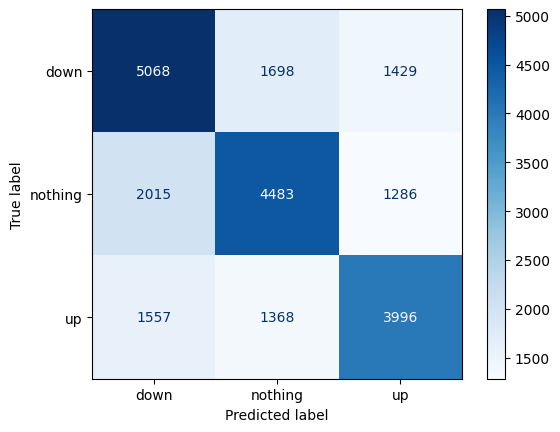

In [283]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_true, all_predicted), #/confusion_matrix(y_test, predictions).sum(),
                                    display_labels=['down', 'nothing', 'up'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [44]:
train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=10, batch_size=32, learning_rate=0.001, device=device)

  0%|          | 1/300 [00:40<3:22:47, 40.69s/it]

[2, 1, 1, 2, 2, 2, 2, 0, 2, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 0 train loss - 0.9690141081809998, eval loss - 0.9316304922103882, accuracy - 0.56


  1%|          | 2/300 [01:21<3:22:01, 40.68s/it]

[2, 1, 1, 2, 2, 2, 2, 0, 2, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 1 train loss - 0.9674702882766724, eval loss - 0.9358499646186829, accuracy - 0.57


  1%|          | 3/300 [02:02<3:22:52, 40.99s/it]

[2, 1, 1, 2, 2, 2, 2, 0, 2, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 2 train loss - 0.966162383556366, eval loss - 0.941631019115448, accuracy - 0.57


  1%|▏         | 4/300 [02:45<3:25:13, 41.60s/it]

[2, 1, 1, 2, 2, 2, 2, 0, 2, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 3 train loss - 0.9650145769119263, eval loss - 0.9460890889167786, accuracy - 0.57


  2%|▏         | 5/300 [03:25<3:21:47, 41.04s/it]

[2, 1, 1, 2, 2, 2, 2, 0, 2, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 4 train loss - 0.9639896750450134, eval loss - 0.9514713287353516, accuracy - 0.57


  2%|▏         | 6/300 [04:05<3:20:26, 40.91s/it]

[2, 1, 2, 2, 2, 2, 2, 0, 2, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 5 train loss - 0.9630535244941711, eval loss - 0.9565962553024292, accuracy - 0.57


  2%|▏         | 7/300 [04:46<3:18:37, 40.67s/it]

[2, 1, 2, 2, 2, 2, 2, 0, 2, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 6 train loss - 0.9621943235397339, eval loss - 0.9617921710014343, accuracy - 0.57


  3%|▎         | 8/300 [05:26<3:17:49, 40.65s/it]

[2, 1, 2, 2, 2, 2, 2, 0, 2, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 7 train loss - 0.9614077210426331, eval loss - 0.967297375202179, accuracy - 0.57


  3%|▎         | 9/300 [06:07<3:17:12, 40.66s/it]

[2, 1, 2, 2, 2, 2, 2, 0, 2, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 8 train loss - 0.9606626033782959, eval loss - 0.9727873802185059, accuracy - 0.57


  3%|▎         | 10/300 [06:47<3:15:24, 40.43s/it]

[2, 1, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 9 train loss - 0.9599701762199402, eval loss - 0.9779704809188843, accuracy - 0.57


  4%|▎         | 11/300 [07:28<3:15:05, 40.50s/it]

[2, 1, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 10 train loss - 0.9593076109886169, eval loss - 0.9820579290390015, accuracy - 0.57


  4%|▍         | 12/300 [08:08<3:14:57, 40.62s/it]

[2, 1, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 11 train loss - 0.9586859345436096, eval loss - 0.98798006772995, accuracy - 0.57


  4%|▍         | 13/300 [08:48<3:13:24, 40.43s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 12 train loss - 0.9581401944160461, eval loss - 0.9934112429618835, accuracy - 0.57


  5%|▍         | 14/300 [09:28<3:12:14, 40.33s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 13 train loss - 0.9576717019081116, eval loss - 0.9975353479385376, accuracy - 0.57


  5%|▌         | 15/300 [10:09<3:11:21, 40.28s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 14 train loss - 0.9572490453720093, eval loss - 1.0006834268569946, accuracy - 0.57


  5%|▌         | 16/300 [10:51<3:13:30, 40.88s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 15 train loss - 0.9568519592285156, eval loss - 1.0034741163253784, accuracy - 0.58


  6%|▌         | 17/300 [11:36<3:19:27, 42.29s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 16 train loss - 0.9564877152442932, eval loss - 1.0054576396942139, accuracy - 0.58


  6%|▌         | 18/300 [12:20<3:20:42, 42.70s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 17 train loss - 0.9561273455619812, eval loss - 1.006139874458313, accuracy - 0.58


  6%|▋         | 19/300 [13:01<3:17:29, 42.17s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 18 train loss - 0.9557902812957764, eval loss - 1.0087542533874512, accuracy - 0.58


  7%|▋         | 20/300 [13:42<3:14:41, 41.72s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 19 train loss - 0.9554526805877686, eval loss - 1.0095757246017456, accuracy - 0.58


  7%|▋         | 21/300 [14:22<3:12:37, 41.42s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 20 train loss - 0.9551482200622559, eval loss - 1.0110992193222046, accuracy - 0.58


  7%|▋         | 22/300 [15:03<3:09:57, 41.00s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 21 train loss - 0.9548454880714417, eval loss - 1.0120675563812256, accuracy - 0.58


  8%|▊         | 23/300 [15:43<3:08:45, 40.89s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 22 train loss - 0.9545483589172363, eval loss - 1.0129005908966064, accuracy - 0.58


  8%|▊         | 24/300 [16:24<3:07:54, 40.85s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 23 train loss - 0.9542609453201294, eval loss - 1.013139009475708, accuracy - 0.58


  8%|▊         | 25/300 [17:04<3:06:24, 40.67s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 24 train loss - 0.9539889097213745, eval loss - 1.0136725902557373, accuracy - 0.58


  9%|▊         | 26/300 [17:44<3:05:05, 40.53s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 25 train loss - 0.9537301063537598, eval loss - 1.0138046741485596, accuracy - 0.58


  9%|▉         | 27/300 [18:25<3:05:07, 40.69s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 26 train loss - 0.9534783363342285, eval loss - 1.014258623123169, accuracy - 0.58


  9%|▉         | 28/300 [19:06<3:04:36, 40.72s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 27 train loss - 0.9532298445701599, eval loss - 1.0145097970962524, accuracy - 0.58


 10%|▉         | 29/300 [19:47<3:04:18, 40.81s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 28 train loss - 0.9529852271080017, eval loss - 1.0145635604858398, accuracy - 0.58


 10%|█         | 30/300 [20:28<3:03:51, 40.86s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 29 train loss - 0.9527435898780823, eval loss - 1.0144528150558472, accuracy - 0.58


 10%|█         | 31/300 [21:11<3:05:36, 41.40s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 30 train loss - 0.9525225758552551, eval loss - 1.0148569345474243, accuracy - 0.58


 11%|█         | 32/300 [21:54<3:06:36, 41.78s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 31 train loss - 0.9523063898086548, eval loss - 1.0163178443908691, accuracy - 0.58


 11%|█         | 33/300 [22:35<3:05:23, 41.66s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 32 train loss - 0.9520913362503052, eval loss - 1.0162922143936157, accuracy - 0.58


 11%|█▏        | 34/300 [23:16<3:04:09, 41.54s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 33 train loss - 0.951880931854248, eval loss - 1.016632318496704, accuracy - 0.58


 12%|█▏        | 35/300 [23:58<3:03:53, 41.64s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 34 train loss - 0.9516810774803162, eval loss - 1.0156633853912354, accuracy - 0.58


 12%|█▏        | 36/300 [24:39<3:02:10, 41.40s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 35 train loss - 0.9514785408973694, eval loss - 1.0158154964447021, accuracy - 0.58


 12%|█▏        | 37/300 [25:20<3:01:08, 41.33s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 36 train loss - 0.9512878656387329, eval loss - 1.0159538984298706, accuracy - 0.58


 13%|█▎        | 38/300 [26:01<3:00:23, 41.31s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 37 train loss - 0.9511131644248962, eval loss - 1.0163390636444092, accuracy - 0.58


 13%|█▎        | 39/300 [26:44<3:00:53, 41.58s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 38 train loss - 0.9509401321411133, eval loss - 1.0160608291625977, accuracy - 0.58


 13%|█▎        | 40/300 [27:25<2:59:49, 41.50s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 39 train loss - 0.950768232345581, eval loss - 1.0166842937469482, accuracy - 0.58


 14%|█▎        | 41/300 [28:05<2:57:47, 41.19s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 40 train loss - 0.9505950212478638, eval loss - 1.01681649684906, accuracy - 0.58


 14%|█▍        | 42/300 [28:51<3:02:17, 42.39s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 41 train loss - 0.9504324793815613, eval loss - 1.0159460306167603, accuracy - 0.58


 14%|█▍        | 43/300 [29:38<3:08:28, 44.00s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 42 train loss - 0.950262725353241, eval loss - 1.016392469406128, accuracy - 0.58


 15%|█▍        | 44/300 [30:27<3:13:57, 45.46s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 43 train loss - 0.9500972032546997, eval loss - 1.0164800882339478, accuracy - 0.58


 15%|█▌        | 45/300 [31:09<3:08:32, 44.36s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 44 train loss - 0.9499462246894836, eval loss - 1.0164976119995117, accuracy - 0.58


 15%|█▌        | 46/300 [31:52<3:06:41, 44.10s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 45 train loss - 0.9497886300086975, eval loss - 1.0171726942062378, accuracy - 0.58


 16%|█▌        | 47/300 [32:34<3:03:17, 43.47s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 46 train loss - 0.9496281147003174, eval loss - 1.017264723777771, accuracy - 0.58


 16%|█▌        | 48/300 [33:17<3:01:30, 43.22s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 47 train loss - 0.9494749903678894, eval loss - 1.0172488689422607, accuracy - 0.58


 16%|█▋        | 49/300 [33:58<2:58:19, 42.63s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 48 train loss - 0.9493198990821838, eval loss - 1.0175358057022095, accuracy - 0.58


 17%|█▋        | 50/300 [34:39<2:55:51, 42.20s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 49 train loss - 0.9491733908653259, eval loss - 1.017783522605896, accuracy - 0.58


 17%|█▋        | 51/300 [35:22<2:56:01, 42.42s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 50 train loss - 0.9490237236022949, eval loss - 1.0180612802505493, accuracy - 0.58


 17%|█▋        | 52/300 [36:05<2:55:54, 42.56s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 51 train loss - 0.9488771557807922, eval loss - 1.0181407928466797, accuracy - 0.58


 18%|█▊        | 53/300 [36:51<2:58:47, 43.43s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 52 train loss - 0.9487353563308716, eval loss - 1.018483281135559, accuracy - 0.58


 18%|█▊        | 54/300 [37:33<2:56:43, 43.10s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 53 train loss - 0.9485974311828613, eval loss - 1.019052267074585, accuracy - 0.58


 18%|█▊        | 55/300 [38:15<2:54:24, 42.71s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 54 train loss - 0.9484559893608093, eval loss - 1.0194339752197266, accuracy - 0.58


 19%|█▊        | 56/300 [38:59<2:55:53, 43.25s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 55 train loss - 0.9483122825622559, eval loss - 1.0193783044815063, accuracy - 0.58


 19%|█▉        | 57/300 [39:40<2:52:26, 42.58s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 56 train loss - 0.9481611251831055, eval loss - 1.0197840929031372, accuracy - 0.58


 19%|█▉        | 58/300 [40:23<2:51:46, 42.59s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 57 train loss - 0.9480237364768982, eval loss - 1.0209789276123047, accuracy - 0.58


 20%|█▉        | 59/300 [41:04<2:49:30, 42.20s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 58 train loss - 0.9478923082351685, eval loss - 1.0218838453292847, accuracy - 0.58


 20%|██        | 60/300 [41:45<2:47:24, 41.85s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 59 train loss - 0.9477530121803284, eval loss - 1.0221256017684937, accuracy - 0.58


 20%|██        | 61/300 [42:26<2:45:16, 41.49s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 60 train loss - 0.9476215839385986, eval loss - 1.0228396654129028, accuracy - 0.58


 21%|██        | 62/300 [43:07<2:43:30, 41.22s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 61 train loss - 0.9475011825561523, eval loss - 1.0230391025543213, accuracy - 0.58


 21%|██        | 63/300 [43:47<2:41:56, 41.00s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 62 train loss - 0.9473615884780884, eval loss - 1.022716760635376, accuracy - 0.58


 21%|██▏       | 64/300 [44:27<2:40:06, 40.71s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 63 train loss - 0.9472302794456482, eval loss - 1.0235494375228882, accuracy - 0.58


 22%|██▏       | 65/300 [45:07<2:38:38, 40.51s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 64 train loss - 0.9470916986465454, eval loss - 1.0240942239761353, accuracy - 0.58


 22%|██▏       | 66/300 [45:49<2:39:39, 40.94s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 65 train loss - 0.9469671249389648, eval loss - 1.0239782333374023, accuracy - 0.58


 22%|██▏       | 67/300 [46:29<2:38:19, 40.77s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 66 train loss - 0.9468363523483276, eval loss - 1.024705171585083, accuracy - 0.58


 23%|██▎       | 68/300 [47:10<2:37:37, 40.77s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 67 train loss - 0.9467170834541321, eval loss - 1.0240691900253296, accuracy - 0.58


 23%|██▎       | 69/300 [47:51<2:36:52, 40.75s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 68 train loss - 0.9465945363044739, eval loss - 1.0246232748031616, accuracy - 0.58


 23%|██▎       | 70/300 [48:31<2:35:11, 40.48s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 69 train loss - 0.9464761018753052, eval loss - 1.025743007659912, accuracy - 0.58


 24%|██▎       | 71/300 [49:11<2:34:06, 40.38s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 70 train loss - 0.9463531970977783, eval loss - 1.0260519981384277, accuracy - 0.58


 24%|██▍       | 72/300 [49:51<2:32:59, 40.26s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 71 train loss - 0.9462347626686096, eval loss - 1.0264242887496948, accuracy - 0.58


 24%|██▍       | 73/300 [50:32<2:32:45, 40.38s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 72 train loss - 0.9461095929145813, eval loss - 1.0276769399642944, accuracy - 0.58


 25%|██▍       | 74/300 [51:12<2:32:24, 40.46s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 73 train loss - 0.9459919929504395, eval loss - 1.0280728340148926, accuracy - 0.58


 25%|██▌       | 75/300 [51:53<2:32:08, 40.57s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 74 train loss - 0.9458704590797424, eval loss - 1.0282920598983765, accuracy - 0.58


 25%|██▌       | 76/300 [52:33<2:30:58, 40.44s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 75 train loss - 0.9457534551620483, eval loss - 1.0287811756134033, accuracy - 0.58


 26%|██▌       | 77/300 [53:13<2:29:46, 40.30s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 76 train loss - 0.9456254839897156, eval loss - 1.0292441844940186, accuracy - 0.58


 26%|██▌       | 78/300 [53:54<2:29:13, 40.33s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 77 train loss - 0.9455029964447021, eval loss - 1.0301074981689453, accuracy - 0.58


 26%|██▋       | 79/300 [54:34<2:28:33, 40.33s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 78 train loss - 0.9453874826431274, eval loss - 1.0308113098144531, accuracy - 0.59


 27%|██▋       | 80/300 [55:15<2:29:12, 40.70s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 79 train loss - 0.9452748894691467, eval loss - 1.031424880027771, accuracy - 0.59


 27%|██▋       | 81/300 [55:58<2:30:09, 41.14s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 80 train loss - 0.9451469779014587, eval loss - 1.0323158502578735, accuracy - 0.59


 27%|██▋       | 82/300 [56:42<2:32:53, 42.08s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 81 train loss - 0.9450219869613647, eval loss - 1.0327982902526855, accuracy - 0.59


 28%|██▊       | 83/300 [57:24<2:31:51, 41.99s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 82 train loss - 0.9449071884155273, eval loss - 1.0329060554504395, accuracy - 0.59


 28%|██▊       | 84/300 [58:04<2:29:32, 41.54s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 83 train loss - 0.944788932800293, eval loss - 1.03287672996521, accuracy - 0.59


 28%|██▊       | 85/300 [58:43<2:25:57, 40.73s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 84 train loss - 0.9446655511856079, eval loss - 1.0333316326141357, accuracy - 0.59


 29%|██▊       | 86/300 [59:22<2:23:16, 40.17s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 85 train loss - 0.9445465207099915, eval loss - 1.0344616174697876, accuracy - 0.59


 29%|██▉       | 87/300 [59:59<2:19:04, 39.17s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 86 train loss - 0.9444376826286316, eval loss - 1.0343724489212036, accuracy - 0.59


 29%|██▉       | 88/300 [1:00:36<2:16:02, 38.50s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 87 train loss - 0.944326639175415, eval loss - 1.0351815223693848, accuracy - 0.59


 30%|██▉       | 89/300 [1:01:11<2:11:35, 37.42s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 88 train loss - 0.9442194700241089, eval loss - 1.0352951288223267, accuracy - 0.59


 30%|███       | 90/300 [1:01:51<2:13:44, 38.21s/it]

[2, 2, 2, 2, 2, 2, 2, 0, 2, 2] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 89 train loss - 0.9441028237342834, eval loss - 1.0357104539871216, accuracy - 0.59


 30%|███       | 90/300 [1:02:20<2:25:27, 41.56s/it]

KeyboardInterrupt



In [ ]:
# train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=50, batch_size=32, learning_rate=0.0001, device=device)

In [ ]:
# train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=50, batch_size=32, learning_rate=0.0001, device=device)

In [ ]:
# train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=100, batch_size=32, learning_rate=0.0001, device=device)

In [ ]:
# 450 эпох

In [ ]:
10 * 10 * 16 * 16

In [ ]:
# train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=10, batch_size=32, learning_rate=0.0001, device=device)

In [ ]:
# train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=30, batch_size=32, learning_rate=0.0001, device=device)

In [ ]:
# train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=100, batch_size=32, learning_rate=0.0001, device=device)

In [284]:
torch.save(simple_model.state_dict(), 'models/simple_model_shift_1_no_lob_25_may')

# Same but with no mm

In [161]:
shift_percentage = {}
shift_percentage['huge_data'] = [(1, 0.0004), (5, 0.001), (10, 0.0017)]
shift_percentage['huge_data_no_mm'] = [(1, 0.00129), (5, 0.002265), (10, 0.003)]
shift_percentage['huge_data_undervalued'] = [(1, 0.0008), (5, 0.0025), (10, 0.004)]
shift_percentage['huge_data_undervalued_no_mm'] = [(1, 0.00105), (5, 0.003), (10, 0.0042)]

In [162]:
device='cuda'

In [163]:
huge_data_features_no_mm = pd.read_csv('data/huge_data_lob_no_mm/huge_data_features.csv')

separation_column = []

for i in range(huge_data_features_no_mm.shape[0]//250):
    separation_column += [i] * 250

huge_data_features_no_mm['sep_col'] = separation_column

current_division = []

for j in range(huge_data_features_no_mm.shape[0] // 250):
    current_division.append(huge_data_features_no_mm[huge_data_features_no_mm['sep_col'] == j].reset_index(drop=True).drop(['sep_col'], axis=1))

huge_data_features_no_mm = current_division

In [164]:
# train_df_5 = prepare_huge_data(huge_data_features_no_mm[:400], shift=shift_percentage['huge_data_no_mm'][1][0], percentage_down=shift_percentage['huge_data_no_mm'][1][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)
# eval_df_5 = prepare_huge_data(huge_data_features_no_mm[400:], shift=shift_percentage['huge_data_no_mm'][1][0], percentage_down=shift_percentage['huge_data_no_mm'][1][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)

train_df_1 = prepare_huge_data(huge_data_features_no_mm[:400], shift=shift_percentage['huge_data_no_mm'][0][0], percentage_down=shift_percentage['huge_data_no_mm'][0][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)
eval_df_1 = prepare_huge_data(huge_data_features_no_mm[400:], shift=shift_percentage['huge_data_no_mm'][0][0], percentage_down=shift_percentage['huge_data_no_mm'][0][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)


loss_f = nn.CrossEntropyLoss()

In [ ]:
train_df_1['difference'].hist()

In [165]:
shift_percentage['huge_data_no_mm'][0][1] + 0.00029

0.0015799999999999998

<Axes: >

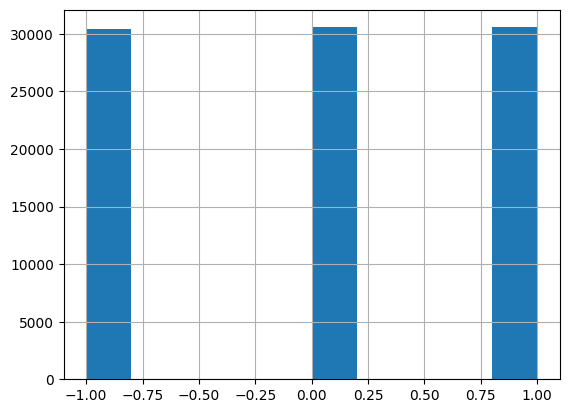

In [166]:
train_df_1['difference'].hist()

In [167]:
random.seed(2114)

# data_y = train_df_5['difference'] + 1
# data_x =  train_df_5.drop(['difference', 'Unnamed: 0'], axis=1)
# train_ds = trainDataset(data_x, data_y, device=device)

# data_y = eval_df_5['difference'] + 1
# data_x =  eval_df_5.drop(['difference', 'Unnamed: 0'], axis=1)
# eval_ds = trainDataset(data_x, data_y, device=device)

data_y = train_df_1['difference'] + 1
data_x =  train_df_1.drop(['difference', 'Unnamed: 0'], axis=1)
train_ds = trainDataset(data_x, data_y, device=device)

data_y = eval_df_1['difference'] + 1
data_x =  eval_df_1.drop(['difference', 'Unnamed: 0'], axis=1)
eval_ds = trainDataset(data_x, data_y, device=device)

In [168]:
torch.manual_seed(2114)
simple_model = SimpleModel()

In [169]:
simple_model.linear.weight[0][0].item()

0.17340821027755737

In [170]:
train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=10, batch_size=32, learning_rate=0.001, device=device)

 10%|█         | 1/10 [00:34<05:14, 34.99s/it]

[2, 0, 2, 0, 2, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 0 train loss - 1.0464214086532593, eval loss - 1.0405455827713013, accuracy - 0.5


 20%|██        | 2/10 [01:09<04:38, 34.86s/it]

[2, 1, 2, 0, 2, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 1 train loss - 1.0047751665115356, eval loss - 1.0016915798187256, accuracy - 0.54


 30%|███       | 3/10 [01:46<04:08, 35.57s/it]

[2, 1, 2, 0, 1, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 2 train loss - 0.9735231399536133, eval loss - 0.9473341703414917, accuracy - 0.58


 40%|████      | 4/10 [02:21<03:33, 35.52s/it]

[2, 2, 2, 1, 1, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 3 train loss - 0.9549182653427124, eval loss - 0.9419384002685547, accuracy - 0.58


 50%|█████     | 5/10 [02:57<02:57, 35.60s/it]

[2, 2, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 4 train loss - 0.9498513340950012, eval loss - 0.9219291806221008, accuracy - 0.59


 60%|██████    | 6/10 [03:32<02:22, 35.55s/it]

[2, 1, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 5 train loss - 0.9477627873420715, eval loss - 0.9053736925125122, accuracy - 0.59


 70%|███████   | 7/10 [04:08<01:46, 35.51s/it]

[2, 1, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 6 train loss - 0.9463107585906982, eval loss - 0.9025923013687134, accuracy - 0.59


 80%|████████  | 8/10 [04:45<01:11, 35.97s/it]

[2, 1, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 7 train loss - 0.944826602935791, eval loss - 0.9016950726509094, accuracy - 0.59


 90%|█████████ | 9/10 [05:21<00:35, 35.94s/it]

[2, 1, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 8 train loss - 0.9436485767364502, eval loss - 0.9080008268356323, accuracy - 0.59


100%|██████████| 10/10 [05:58<00:00, 35.80s/it]

[2, 1, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 9 train loss - 0.9425754547119141, eval loss - 0.9106395840644836, accuracy - 0.59


In [171]:
train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=10, batch_size=32, learning_rate=0.0001, device=device)

 10%|█         | 1/10 [00:34<05:12, 34.78s/it]

[2, 1, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 0 train loss - 0.9327831268310547, eval loss - 0.9323390126228333, accuracy - 0.6


 20%|██        | 2/10 [01:10<04:42, 35.37s/it]

[2, 2, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 1 train loss - 0.9323771595954895, eval loss - 0.9342131614685059, accuracy - 0.6


 30%|███       | 3/10 [01:47<04:12, 36.03s/it]

[2, 2, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 2 train loss - 0.9321413040161133, eval loss - 0.935559868812561, accuracy - 0.6


 40%|████      | 4/10 [02:23<03:36, 36.12s/it]

[2, 2, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 3 train loss - 0.9319620728492737, eval loss - 0.9352383613586426, accuracy - 0.6


 50%|█████     | 5/10 [03:03<03:06, 37.31s/it]

[2, 2, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 4 train loss - 0.9318162202835083, eval loss - 0.9348440170288086, accuracy - 0.6


 60%|██████    | 6/10 [03:41<02:30, 37.67s/it]

[2, 2, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 5 train loss - 0.9316965937614441, eval loss - 0.9348965883255005, accuracy - 0.6


 70%|███████   | 7/10 [04:15<01:49, 36.39s/it]

[2, 2, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 6 train loss - 0.9315827488899231, eval loss - 0.935131847858429, accuracy - 0.6


 80%|████████  | 8/10 [04:48<01:10, 35.46s/it]

[2, 2, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 7 train loss - 0.9314858913421631, eval loss - 0.9357062578201294, accuracy - 0.6


 90%|█████████ | 9/10 [05:25<00:35, 35.87s/it]

[2, 2, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 8 train loss - 0.9313887357711792, eval loss - 0.9360437393188477, accuracy - 0.6


100%|██████████| 10/10 [06:02<00:00, 36.20s/it]

[2, 2, 2, 0, 0, 0, 0, 0, 2, 0] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 9 train loss - 0.9312877058982849, eval loss - 0.9361984133720398, accuracy - 0.6


In [124]:
torch.save(simple_model.state_dict(), 'models/simple_model_shift_1_no_lob_24_may_no_mm')

In [193]:
# setting

shift = 1


# model

my_model = SimpleModel()

my_model.load_state_dict(torch.load('models/simple_model_shift_1_no_lob_21_may'))
my_model.to('cuda')


# data
huge_data_features_no_mm = pd.read_csv('data/huge_data_lob/huge_data_features.csv')

separation_column = []

for i in range(huge_data_features_no_mm.shape[0]//250):
    separation_column += [i] * 250

huge_data_features_no_mm['sep_col'] = separation_column

current_division = []

for j in range(huge_data_features_no_mm.shape[0] // 250):
    current_division.append(huge_data_features_no_mm[huge_data_features_no_mm['sep_col'] == j].reset_index(drop=True).drop(['sep_col'], axis=1))

huge_data_features_no_mm = current_division

# data transforming

if shift == 5:
    train_df_5 = prepare_huge_data(huge_data_features_no_mm[:400], shift=shift_percentage['huge_data_no_mm'][1][0], percentage_down=shift_percentage['huge_data_no_mm'][1][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)
    eval_df_5 = prepare_huge_data(huge_data_features_no_mm[400:], shift=shift_percentage['huge_data_no_mm'][1][0], percentage_down=shift_percentage['huge_data_no_mm'][1][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)

if shift == 1:
    train_df_1 = prepare_huge_data(huge_data_features_no_mm[:400], shift=shift_percentage['huge_data_no_mm'][0][0], percentage_down=shift_percentage['huge_data_no_mm'][0][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)
    eval_df_1 = prepare_huge_data(huge_data_features_no_mm[400:], shift=shift_percentage['huge_data_no_mm'][0][0], percentage_down=shift_percentage['huge_data_no_mm'][0][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)


if shift == 5:
    data_y = train_df_5['difference'] + 1
    data_x =  train_df_5.drop(['difference', 'Unnamed: 0'], axis=1)
    train_ds = trainDataset(data_x, data_y, device=device)

    data_y = eval_df_5['difference'] + 1
    data_x =  eval_df_5.drop(['difference', 'Unnamed: 0'], axis=1)
    eval_ds = trainDataset(data_x, data_y, device=device)


if shift == 1:
    data_y = train_df_1['difference'] + 1
    data_x =  train_df_1.drop(['difference', 'Unnamed: 0'], axis=1)
    train_ds = trainDataset(data_x, data_y, device=device)

    data_y = eval_df_1['difference'] + 1
    data_x =  eval_df_1.drop(['difference', 'Unnamed: 0'], axis=1)
    eval_ds = trainDataset(data_x, data_y, device=device)






all_true = []
all_predicted = []

my_model.eval()

for batch in tqdm(eval_ds):
    x = batch[0]
    y = batch[1]
    
    all_true.append(y.item())
    
    y_pred = my_model(x.unsqueeze(0))
    
    prediction = torch.argmax(y_pred, dim=1)
    all_predicted.append(prediction.item())
    
    
#     print(all_predicted, all_true)

100%|██████████| 22900/22900 [00:25<00:00, 907.83it/s]


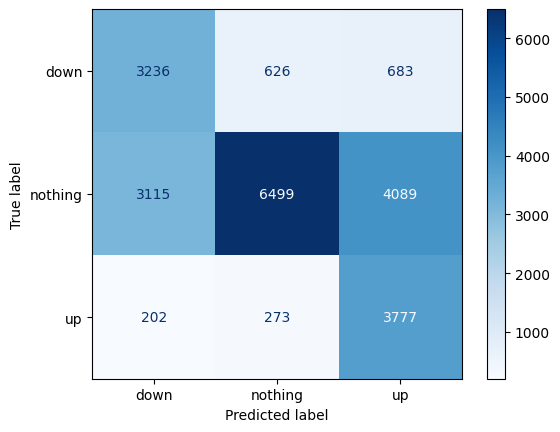

In [192]:
# shift 5 mm

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_true, all_predicted), #/confusion_matrix(y_test, predictions).sum(),
                                    display_labels=['down', 'nothing', 'up'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

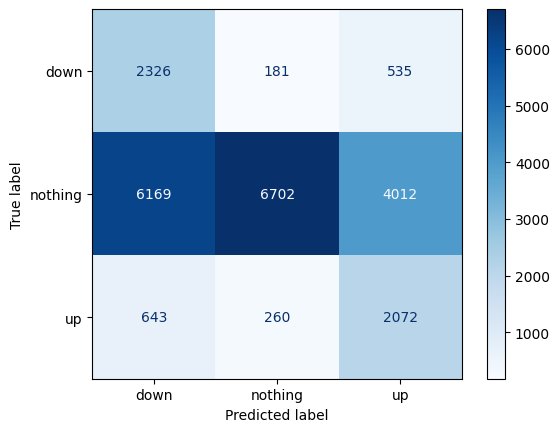

In [194]:
# shift 1 mm

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_true, all_predicted), #/confusion_matrix(y_test, predictions).sum(),
                                    display_labels=['down', 'nothing', 'up'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

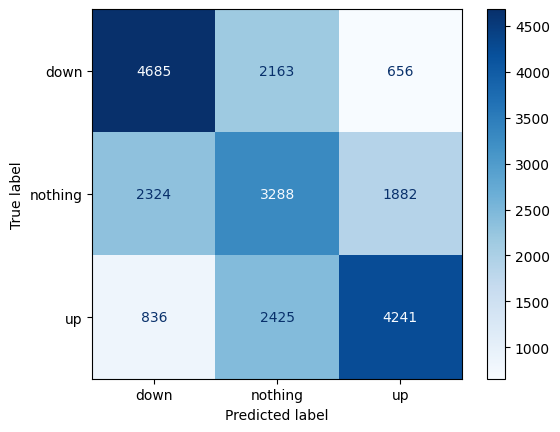

In [190]:
# shift 5 no mm
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_true, all_predicted), #/confusion_matrix(y_test, predictions).sum(),
                                    display_labels=['down', 'nothing', 'up'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

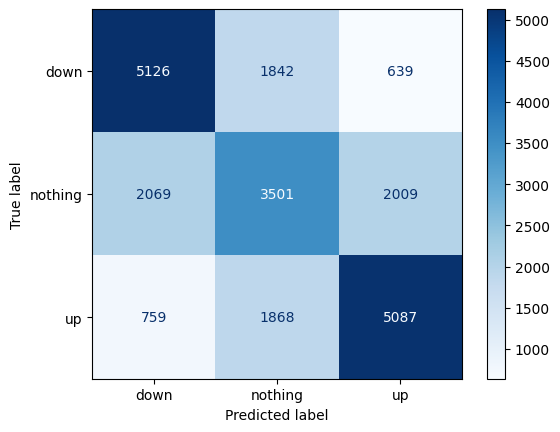

In [184]:
# shift 1 no mm 

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_true, all_predicted), #/confusion_matrix(y_test, predictions).sum(),
                                    display_labels=['down', 'nothing', 'up'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Training LSTM

In [ ]:
train_df_5 = prepare_huge_data(new_huge_data_features[:400], shift=shift_percentage['huge_data'][1][0], percentage_down=shift_percentage['huge_data'][1][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)
eval_df_5 = prepare_huge_data(new_huge_data_features[400:], shift=shift_percentage['huge_data'][1][0], percentage_down=shift_percentage['huge_data'][1][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)

loss_f = nn.CrossEntropyLoss()

In [160]:
train_ds[0]

(tensor([ 1.5789e-01,  2.3077e-01,  1.5686e-01, -6.1611e-02, -1.0769e-01,
          2.1455e-01,  1.3025e-01,  1.2651e-01,  6.5000e+01,  1.0048e+00,
          1.0010e-03,  5.0050e-04,  7.5075e-04, -7.5075e-04,  2.0020e-03,
          3.8182e-03], device='cuda:0'),
 tensor([1], device='cuda:0'))

In [172]:
lstm_model = LSTM_model_5()

In [173]:
torch.Tensor([1, 2, 3]).unsqueeze(0).shape

torch.Size([1, 3])

In [175]:
train_lstm(lstm_model, train_ds, eval_ds, loss_f, n_epoch=30, batch_size=32, learning_rate=0.001, device=device)

  5%|▍         | 4179/91595 [00:30<11:33, 125.99it/s]


  9%|▉         | 8294/91595 [01:00<11:41, 118.75it/s]


 13%|█▎        | 12353/91595 [01:31<09:28, 139.31it/s]


 18%|█▊        | 16432/91595 [02:01<09:09, 136.79it/s]


 22%|██▏       | 20552/91595 [02:31<09:40, 122.33it/s]


 27%|██▋       | 24571/91595 [03:02<07:44, 144.27it/s]


 31%|███       | 28583/91595 [03:32<07:48, 134.61it/s]


 36%|███▌      | 32638/91595 [04:02<07:14, 135.77it/s]


 40%|████      | 36663/91595 [04:32<07:17, 125.46it/s]


 44%|████▍     | 40658/91595 [05:02<08:12, 103.49it/s]


 48%|████▊     | 44260/91595 [05:32<06:34, 119.97it/s]


 52%|█████▏    | 47997/91595 [06:02<05:21, 135.48it/s]


 57%|█████▋    | 52096/91595 [06:33<04:42, 139.60it/s]


 61%|██████▏   | 56272/91595 [07:05<05:08, 114.34it/s]


 66%|██████▌   | 60356/91595 [07:35<03:45, 138.53it/s]


 70%|███████   | 64239/91595 [08:06<03:14, 140.30it/s]


 75%|███████▍  | 68293/91595 [08:36<03:09, 123.28it/s]


 79%|███████▉  | 72386/91595 [09:06<02:16, 141.03it/s]


 83%|████████▎ | 76433/91595 [09:36<01:53, 133.17it/s]


 88%|████████▊ | 80593/91595 [10:06<01:27, 126.41it/s]


 92%|█████████▏| 84431/91595 [10:36<00:50, 143.25it/s]


 97%|█████████▋| 88430/91595 [11:07<00:22, 141.13it/s]


100%|██████████| 91595/91595 [11:30<00:00, 132.63it/s]

 10%|▉         | 2228/22895 [00:07<01:13, 282.68it/s]


 44%|████▍     | 10129/22895 [00:37<00:46, 273.71it/s]


 80%|████████  | 18352/22895 [01:07<00:20, 224.48it/s]


  3%|▎         | 1/30 [12:58<6:16:25, 778.83s/it]

[2, 2, 0, 2, 0, 0, 0, 0, 0, 2] [1, 1, 2, 2, 1, 0, 0, 0, 2, 0]
epoch 0 train loss - 0.9533754587173462, eval loss - 0.9558583498001099, accuracy - 0.3



  5%|▍         | 4189/91595 [00:30<10:19, 141.17it/s]


  9%|▉         | 8250/91595 [01:01<10:00, 138.69it/s]


 13%|█▎        | 12099/91595 [01:32<13:39, 97.04it/s] 


 17%|█▋        | 15887/91595 [02:03<08:46, 143.81it/s]


 22%|██▏       | 19933/91595 [02:33<08:44, 136.66it/s]


 26%|██▌       | 23981/91595 [03:03<09:18, 121.02it/s]


 31%|███       | 27989/91595 [03:34<07:35, 139.59it/s]


 35%|███▍      | 32029/91595 [04:04<07:43, 128.64it/s]


 40%|███▉      | 36256/91595 [04:34<07:32, 122.36it/s]


 43%|████▎     | 39734/91595 [05:04<07:21, 117.43it/s]


  3%|▎         | 1/30 [18:32<8:57:49, 1112.75s/it]

KeyboardInterrupt



## Training - features + LOB

In [20]:
500 * 0.8

400.0

In [132]:
train_df_5 = prepare_huge_data(new_huge_data_features[:400], shift=shift_percentage['huge_data'][1][0], percentage_down=shift_percentage['huge_data'][1][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)
eval_df_5 = prepare_huge_data(new_huge_data_features[400:], shift=shift_percentage['huge_data'][1][0], percentage_down=shift_percentage['huge_data'][1][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)

loss_f = nn.CrossEntropyLoss()

In [137]:
train_df_5.head()

,Unnamed: 0,bid_ask_volume_imbalance_1,bid_ask_volume_imbalance_3,bid_ask_volume_imbalance_5,bid_ask_volume_imbalance_10,sign_transaction_volume_1,sign_transaction_volume_5,sign_transaction_volume_10,sign_transaction_volume_20,all_transaction_volume_1,dividends_previous_divided,return_1,return_5,return_10,return_20,difference,bid_ask_spread_percentage,fundamental_v_norm
0,20,0.157895,0.230769,0.156863,-0.061611,-0.107692,0.214545,0.130252,0.126513,65,1.004824,0.001001,0.000501,0.000751,-0.000751,0,0.002002,0.003818
1,21,-0.565217,-0.538462,-0.428571,-0.325967,-0.360000,0.112782,0.120654,0.121577,50,1.000242,0.000000,-0.001502,0.001001,-0.000751,1,0.009009,0.000242
2,22,-0.703704,0.674009,0.437037,0.197802,-0.463415,0.030075,0.067210,0.096703,41,0.999022,0.004732,0.006476,0.005479,0.003985,0,0.001494,-0.005705
3,23,0.939394,0.815789,0.718876,0.362162,-0.137931,-0.090909,0.030303,0.064200,58,0.998005,0.000498,0.008215,0.004481,0.005975,-1,0.000498,-0.002492
4,24,0.898990,0.831776,0.781659,0.607717,0.368421,-0.150794,0.070994,0.064018,38,1.000087,-0.005759,0.000501,0.000501,-0.000751,1,0.010015,0.005846


In [94]:
iteration_indeces = train_df_5['Unnamed: 0'].unique()

min_iteration_indeces = min(iteration_indeces)
max_iteration_indeces = max(iteration_indeces)

In [95]:
max_iteration_indeces

244

In [96]:
device='cuda'

In [97]:
train_ds = trainDataset_w_LOB(train_df_5.drop(['Unnamed: 0', 'difference'], axis=1), 
                                  train_df_5['difference'] + 1, min_iteration_indeces, max_iteration_indeces, 
                                  huge_data_bid, huge_data_ask, device=device)

eval_ds = trainDataset_w_LOB(eval_df_5.drop(['Unnamed: 0', 'difference'], axis=1), 
                                  eval_df_5['difference'] + 1, min_iteration_indeces, max_iteration_indeces, 
                                  huge_data_bid, huge_data_ask, device=device)

In [98]:
train_ds[3][0][20:]

tensor([197.1000, 197.2000, 197.3000, 197.4000, 197.5000, 197.7000, 197.8000,
        197.9000, 198.0000, 198.1000, 198.2000, 198.3000,   3.0000,   6.0000,
          5.0000,   9.0000,   4.0000,   3.0000,   3.0000,   3.0000,   5.0000,
          8.0000,   1.0000,   9.0000,  19.0000,   1.0000,   3.0000,   4.0000,
        200.7000, 200.8000, 201.0000, 201.1000, 201.2000, 201.3000, 201.4000,
        201.5000, 201.6000, 201.7000, 201.8000, 201.9000, 202.0000, 202.1000,
        202.2000, 202.3000,   1.0000,   5.0000,   5.0000,  10.0000,   2.0000,
         12.0000,   8.0000,  14.0000,  25.0000,  16.0000,  20.0000,   4.0000,
         17.0000,   9.0000,   7.0000,   1.0000], device='cuda:0')

In [106]:
simple_model.train()

SimpleModel_LOB(
  (linear): Linear(in_features=80, out_features=160, bias=True)
  (linear2): Linear(in_features=160, out_features=220, bias=True)
  (linear3): Linear(in_features=220, out_features=160, bias=True)
  (linear4): Linear(in_features=160, out_features=80, bias=True)
  (linear5): Linear(in_features=80, out_features=40, bias=True)
  (linear6): Linear(in_features=40, out_features=20, bias=True)
  (linear7): Linear(in_features=20, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
)

### simple connected nn

In [108]:
random.seed(2114)
torch.manual_seed(2114)
simple_model = SimpleModel_LOB()

In [109]:
device='cuda'

In [110]:
train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=10, batch_size=32, learning_rate=0.001, device=device)

 10%|█         | 1/10 [02:57<26:36, 177.38s/it]

[2, 1, 2, 1, 1, 1, 1, 0, 1, 0] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 0 train loss - 1.0497968196868896, eval loss - 0.8333041667938232, accuracy - 0.33


 20%|██        | 2/10 [05:54<23:38, 177.35s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 1 train loss - 1.0180805921554565, eval loss - 1.3850901126861572, accuracy - 0.33


 30%|███       | 3/10 [08:51<20:38, 176.99s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 2 train loss - 1.0060679912567139, eval loss - 1.4851425886154175, accuracy - 0.34


 40%|████      | 4/10 [11:47<17:40, 176.78s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 3 train loss - 0.9992679953575134, eval loss - 1.4775500297546387, accuracy - 0.34


 50%|█████     | 5/10 [14:44<14:44, 176.88s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 4 train loss - 0.995644211769104, eval loss - 1.4008336067199707, accuracy - 0.34


 60%|██████    | 6/10 [17:41<11:47, 176.82s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 5 train loss - 0.9930253624916077, eval loss - 1.480647087097168, accuracy - 0.34


 70%|███████   | 7/10 [20:38<08:50, 176.72s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 6 train loss - 0.9928868412971497, eval loss - 1.4722437858581543, accuracy - 0.35


 80%|████████  | 8/10 [23:34<05:53, 176.69s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 7 train loss - 0.9900006055831909, eval loss - 1.4776896238327026, accuracy - 0.34


 90%|█████████ | 9/10 [26:31<02:56, 176.82s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 8 train loss - 0.9867749810218811, eval loss - 1.4590308666229248, accuracy - 0.35


100%|██████████| 10/10 [29:29<00:00, 176.97s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 9 train loss - 0.9858739972114563, eval loss - 1.527721881866455, accuracy - 0.35


In [111]:
train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=10, batch_size=32, learning_rate=0.001, device=device)

 10%|█         | 1/10 [02:55<26:15, 175.07s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 0 train loss - 0.9832163453102112, eval loss - 1.5505268573760986, accuracy - 0.35


 20%|██        | 2/10 [05:52<23:31, 176.42s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 1 train loss - 0.9823629856109619, eval loss - 1.4780490398406982, accuracy - 0.35


 30%|███       | 3/10 [08:47<20:29, 175.64s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 2 train loss - 0.980043351650238, eval loss - 1.4092750549316406, accuracy - 0.36


 40%|████      | 4/10 [11:43<17:35, 175.90s/it]

[2, 0, 2, 1, 1, 1, 2, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 3 train loss - 0.9796633720397949, eval loss - 1.5423285961151123, accuracy - 0.35


 50%|█████     | 5/10 [14:40<14:41, 176.22s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 4 train loss - 0.98161381483078, eval loss - 1.4357571601867676, accuracy - 0.37


 60%|██████    | 6/10 [17:38<11:47, 176.95s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 5 train loss - 0.9754970073699951, eval loss - 1.5415151119232178, accuracy - 0.36


 70%|███████   | 7/10 [20:42<08:58, 179.37s/it]

[2, 0, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 6 train loss - 0.9739884734153748, eval loss - 1.4570369720458984, accuracy - 0.37


 80%|████████  | 8/10 [23:40<05:57, 178.70s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 7 train loss - 0.9741814732551575, eval loss - 1.4184499979019165, accuracy - 0.39


 90%|█████████ | 9/10 [26:36<02:58, 178.05s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 8 train loss - 0.9709218740463257, eval loss - 1.4919047355651855, accuracy - 0.38


100%|██████████| 10/10 [29:32<00:00, 177.30s/it]

[2, 0, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 9 train loss - 0.9676986932754517, eval loss - 1.413067102432251, accuracy - 0.43


In [113]:
train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=10, batch_size=32, learning_rate=0.001, device=device)

 10%|█         | 1/10 [02:54<26:11, 174.66s/it]

[2, 2, 2, 1, 0, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 0 train loss - 0.9662962555885315, eval loss - 1.382601261138916, accuracy - 0.43


 20%|██        | 2/10 [05:51<23:27, 175.89s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 1 train loss - 0.9633434414863586, eval loss - 1.4623771905899048, accuracy - 0.43


 30%|███       | 3/10 [08:45<20:24, 174.87s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 2 train loss - 0.9609403610229492, eval loss - 1.4119218587875366, accuracy - 0.46


 40%|████      | 4/10 [11:38<17:26, 174.47s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 3 train loss - 0.9592384696006775, eval loss - 1.5499730110168457, accuracy - 0.44


 50%|█████     | 5/10 [14:38<14:42, 176.46s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 4 train loss - 0.9565778970718384, eval loss - 1.4661561250686646, accuracy - 0.45


 60%|██████    | 6/10 [17:35<11:45, 176.41s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 5 train loss - 0.9546008110046387, eval loss - 1.4277994632720947, accuracy - 0.47


 70%|███████   | 7/10 [20:32<08:49, 176.53s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 6 train loss - 0.9554404616355896, eval loss - 1.4097243547439575, accuracy - 0.48


 80%|████████  | 8/10 [23:28<05:52, 176.45s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 7 train loss - 0.9532373547554016, eval loss - 1.444068431854248, accuracy - 0.48


 90%|█████████ | 9/10 [26:27<02:57, 177.28s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 8 train loss - 0.9517688155174255, eval loss - 1.4291574954986572, accuracy - 0.48


100%|██████████| 10/10 [29:22<00:00, 176.26s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 9 train loss - 0.9534675478935242, eval loss - 1.4478065967559814, accuracy - 0.46


In [114]:
train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=20, batch_size=32, learning_rate=0.001, device=device)

  5%|▌         | 1/20 [02:56<55:45, 176.08s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 0 train loss - 0.9510678052902222, eval loss - 1.442147970199585, accuracy - 0.47


 10%|█         | 2/20 [05:59<54:09, 180.51s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 1 train loss - 0.9514442086219788, eval loss - 1.4054465293884277, accuracy - 0.48


 15%|█▌        | 3/20 [09:05<51:49, 182.94s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 2 train loss - 0.9710029363632202, eval loss - 1.4383195638656616, accuracy - 0.49


 20%|██        | 4/20 [11:58<47:42, 178.90s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 3 train loss - 0.9521061182022095, eval loss - 1.4601155519485474, accuracy - 0.48


 25%|██▌       | 5/20 [14:52<44:18, 177.26s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 4 train loss - 0.9482793807983398, eval loss - 1.4427123069763184, accuracy - 0.46


 30%|███       | 6/20 [17:46<41:03, 175.96s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 5 train loss - 0.9494102001190186, eval loss - 1.42628014087677, accuracy - 0.48


 35%|███▌      | 7/20 [20:38<37:54, 174.95s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 6 train loss - 0.9548155665397644, eval loss - 1.4166042804718018, accuracy - 0.48


 40%|████      | 8/20 [23:31<34:50, 174.25s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 7 train loss - 0.9509142637252808, eval loss - 1.4470487833023071, accuracy - 0.49


 45%|████▌     | 9/20 [26:23<31:49, 173.60s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 8 train loss - 0.955265462398529, eval loss - 1.3900258541107178, accuracy - 0.48


 50%|█████     | 10/20 [29:15<28:51, 173.15s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 9 train loss - 0.9479488134384155, eval loss - 1.4746553897857666, accuracy - 0.48


 55%|█████▌    | 11/20 [32:08<25:56, 172.97s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 10 train loss - 0.9484294652938843, eval loss - 1.3948854207992554, accuracy - 0.49


 60%|██████    | 12/20 [35:01<23:02, 172.84s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 11 train loss - 0.9554808139801025, eval loss - 1.3996988534927368, accuracy - 0.49


 65%|██████▌   | 13/20 [37:53<20:08, 172.68s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 12 train loss - 0.9492482542991638, eval loss - 1.4004946947097778, accuracy - 0.48


 70%|███████   | 14/20 [40:45<17:15, 172.58s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 13 train loss - 0.9460552930831909, eval loss - 1.4833011627197266, accuracy - 0.48


 75%|███████▌  | 15/20 [43:42<14:28, 173.71s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 14 train loss - 0.9492710828781128, eval loss - 1.4784905910491943, accuracy - 0.47


 80%|████████  | 16/20 [46:34<11:33, 173.39s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 15 train loss - 0.9512895345687866, eval loss - 1.3981560468673706, accuracy - 0.48


 85%|████████▌ | 17/20 [49:27<08:39, 173.18s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 16 train loss - 0.9492138624191284, eval loss - 1.5514295101165771, accuracy - 0.37


 90%|█████████ | 18/20 [52:19<05:46, 173.01s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 17 train loss - 0.9664123058319092, eval loss - 1.4705686569213867, accuracy - 0.48


 95%|█████████▌| 19/20 [55:12<02:52, 172.81s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 18 train loss - 0.945680558681488, eval loss - 1.463094711303711, accuracy - 0.5


100%|██████████| 20/20 [58:05<00:00, 174.26s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 19 train loss - 0.9481216073036194, eval loss - 1.4215383529663086, accuracy - 0.49


In [115]:
train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=20, batch_size=32, learning_rate=0.001, device=device)

  5%|▌         | 1/20 [02:51<54:26, 171.91s/it]

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 0 train loss - 0.945277988910675, eval loss - 1.4013633728027344, accuracy - 0.49


 10%|█         | 2/20 [05:41<51:04, 170.27s/it]

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1] [2, 2, 2, 2, 1, 1, 1, 0, 1, 1]
epoch 1 train loss - 0.9468558430671692, eval loss - 1.447515845298767, accuracy - 0.48


 10%|█         | 2/20 [07:33<1:08:05, 226.95s/it]

KeyboardInterrupt



In [ ]:
torch.save(simple_model.state_dict(), 'models/simple_model_with_lob_17_may')

In [ ]:
train_nn(simple_model, train_ds, eval_ds, loss_f, n_epoch=250, batch_size=32, learning_rate=0.0001, device=device)

  0%|          | 1/250 [01:20<5:32:36, 80.15s/it]

epoch 0 train loss - 0.9262692332267761, eval loss - 0.9779621362686157, accuracy - 0.55


  1%|          | 2/250 [02:45<5:42:43, 82.92s/it]

epoch 1 train loss - 0.9226465225219727, eval loss - 0.9782137870788574, accuracy - 0.55


  1%|          | 3/250 [03:58<5:24:23, 78.80s/it]

epoch 2 train loss - 0.9271547198295593, eval loss - 0.9983683824539185, accuracy - 0.52


  2%|▏         | 4/250 [05:09<5:09:12, 75.41s/it]

epoch 3 train loss - 0.927007257938385, eval loss - 0.9825842976570129, accuracy - 0.54


In [ ]:
torch.save(simple_model.state_dict(), 'models/simple_model_with_lob_1_2')

# Training LOB only

In [125]:
shift_percentage['huge_data']

[(1, 0.0004), (5, 0.001), (10, 0.0017)]

In [116]:
train_df_5 = prepare_huge_data(new_huge_data_features[:400], shift=shift_percentage['huge_data'][1][0], percentage_down=shift_percentage['huge_data'][1][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)
eval_df_5 = prepare_huge_data(new_huge_data_features[400:], shift=shift_percentage['huge_data'][1][0], percentage_down=shift_percentage['huge_data'][1][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)

loss_f = nn.CrossEntropyLoss()

iteration_indeces = train_df_5['Unnamed: 0'].unique()

min_iteration_indeces = min(iteration_indeces)
max_iteration_indeces = max(iteration_indeces)

In [126]:
train_df_1 = prepare_huge_data(new_huge_data_features[:400], shift=shift_percentage['huge_data'][0][0], percentage_down=shift_percentage['huge_data'][0][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)
eval_df_1 = prepare_huge_data(new_huge_data_features[400:], shift=shift_percentage['huge_data'][0][0], percentage_down=shift_percentage['huge_data'][0][1]).drop(['future_price', 'index', 'dividends', 'price', 'fundamental_v', 'trajectory_number'], axis=1)

loss_f = nn.CrossEntropyLoss()

iteration_indeces = train_df_1['Unnamed: 0'].unique()

min_iteration_indeces = min(iteration_indeces)
max_iteration_indeces = max(iteration_indeces)

In [148]:
huge_data_bid[0][248]

,Unnamed: 0,price,qty
0,351,196.4,17
1,352,196.5,13
2,353,196.6,13
3,354,196.7,13
4,355,196.8,6
5,356,196.9,9
6,357,197.0,18
7,358,197.1,8
8,359,197.2,13
9,360,197.3,14


In [149]:
train_ds[max_iteration_indeces-20][0]

tensor([196.4000, 196.5000, 196.6000, 196.7000, 196.8000, 196.9000, 197.0000,
        197.1000, 197.2000, 197.3000, 197.4000, 197.5000, 197.6000, 197.7000,
        197.8000, 197.9000,  17.0000,  13.0000,  13.0000,  13.0000,   6.0000,
          9.0000,  18.0000,   8.0000,  13.0000,  14.0000,  33.0000,  16.0000,
          5.0000,  12.0000,   6.0000, 163.0000, 199.3000, 199.5000, 199.6000,
        199.7000, 199.8000, 199.9000, 200.0000, 200.1000, 200.2000, 200.3000,
        200.4000, 200.5000, 200.6000, 200.7000, 200.8000, 200.9000,   5.0000,
          4.0000,  48.0000,   7.0000,  15.0000,  20.0000,  15.0000,  21.0000,
          8.0000,   5.0000,  15.0000,   5.0000,   8.0000,  11.0000,   8.0000,
          5.0000], device='cuda:0')

In [147]:
max_iteration_indeces

248

In [127]:
device='cuda'

In [141]:
train_ds = trainDataset_only_LOB(train_df_1.drop(['Unnamed: 0', 'difference'], axis=1), 
                                  train_df_1['difference'] + 1, min_iteration_indeces, max_iteration_indeces, 
                                  huge_data_bid, huge_data_ask, device=device)

eval_ds = trainDataset_only_LOB(eval_df_1.drop(['Unnamed: 0', 'difference'], axis=1), 
                                  eval_df_1['difference'] + 1, min_iteration_indeces, max_iteration_indeces, 
                                  huge_data_bid, huge_data_ask, device=device)

In [129]:
train_ds[0][0].shape

torch.Size([64])

In [130]:
model_lob_only = SimpleModel_LOB_only()

In [131]:
train_nn(model_lob_only, train_ds, eval_ds, loss_f, n_epoch=20, batch_size=32, learning_rate=0.001, device=device)

  5%|▌         | 1/20 [02:44<52:01, 164.27s/it]

[1, 0, 1, 1, 1, 0, 0, 1, 1, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 0 train loss - 1.0403717756271362, eval loss - 1.244534969329834, accuracy - 0.32


 10%|█         | 2/20 [05:25<48:45, 162.55s/it]

[1, 0, 1, 1, 1, 0, 0, 1, 1, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 1 train loss - 1.0156575441360474, eval loss - 1.2378863096237183, accuracy - 0.34


 15%|█▌        | 3/20 [08:14<46:55, 165.59s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 2 train loss - 1.0072848796844482, eval loss - 1.2381069660186768, accuracy - 0.32


 20%|██        | 4/20 [11:03<44:27, 166.74s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 3 train loss - 1.0022051334381104, eval loss - 1.2410402297973633, accuracy - 0.33


 25%|██▌       | 5/20 [13:44<41:12, 164.82s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 4 train loss - 0.9973646998405457, eval loss - 1.2559181451797485, accuracy - 0.33


 30%|███       | 6/20 [16:23<38:00, 162.88s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 5 train loss - 0.9942637085914612, eval loss - 1.2509102821350098, accuracy - 0.33


 35%|███▌      | 7/20 [19:02<35:00, 161.61s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 6 train loss - 0.9915004372596741, eval loss - 1.2570340633392334, accuracy - 0.33


 40%|████      | 8/20 [21:43<32:15, 161.26s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 7 train loss - 0.9903687834739685, eval loss - 1.2679187059402466, accuracy - 0.34


 45%|████▌     | 9/20 [24:23<29:29, 160.84s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 8 train loss - 0.9884146451950073, eval loss - 1.2748420238494873, accuracy - 0.33


 50%|█████     | 10/20 [27:02<26:42, 160.25s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1, 1, 1, 1, 0, 0, 2, 0, 2, 1]
epoch 9 train loss - 0.987427830696106, eval loss - 1.2509410381317139, accuracy - 0.33


 50%|█████     | 10/20 [27:07<27:07, 162.74s/it]


KeyboardInterrupt: 